<a href="https://colab.research.google.com/github/Biniyamgd/IDP/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#progress

!pip install dlib
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=759dd49c87ee9ae4686c4359bae37df7e16514a563a051c69e132a91513d8917
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(f'./sample_data/{filename}', 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


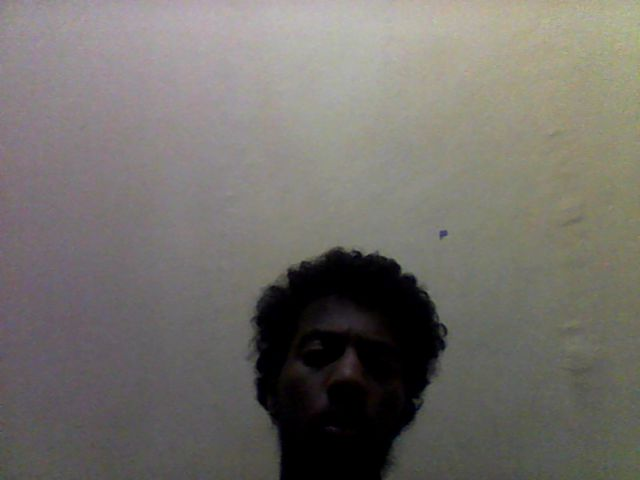

In [20]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<function matplotlib.pyplot.show(close=None, block=None)>

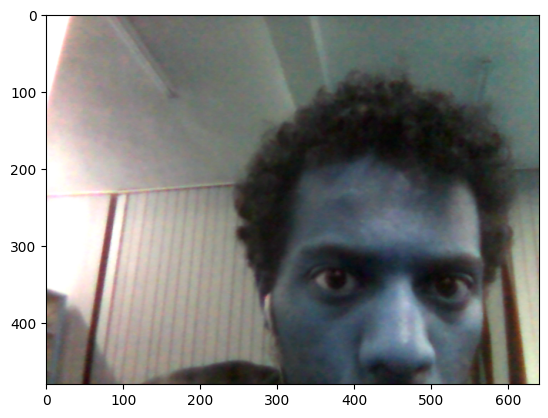

In [ ]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
img= cv2.imread('./photo.jpg')
plt.imshow(img)
plt.show

In [6]:
import cv2
import os
import face_recognition

filepath='./'
folder=os.listdir(filepath)
modelist=[]
stuid=[]
encodeList=[]
for Path in folder:
  # if os.path.isfile(os.path.join(filepath, Path)) and Path.lower().endswith(('.png', '.jpg', '.jpeg')):
    modelist.append(cv2.imread(os.path.join(filepath,Path)))

print(modelist[2])


def encodingImg(Img):
  # for img in Img:
    img=cv2.cvtColor(Img,cv2.COLOR_BGR2RGB)
    encode=face_recognition.face_encodings(img)
    encodeList.append(encode)
    return encodeList

print('encoding Started...')
encodes=encodingImg(modelist[2])
print('encoding Complete...')
print(encodes)

[[[140 122 139]
  [139 121 138]
  [136 120 137]
  ...
  [144 177 170]
  [139 173 166]
  [134 168 161]]

 [[144 126 143]
  [143 126 140]
  [140 124 141]
  ...
  [139 173 166]
  [139 173 166]
  [137 174 166]]

 [[145 128 142]
  [145 128 141]
  [141 126 140]
  ...
  [133 167 161]
  [134 170 164]
  [136 174 168]]

 ...

 [[ 76  86  73]
  [ 75  85  72]
  [ 72  82  70]
  ...
  [ 67  96  81]
  [ 68  97  82]
  [ 69  98  83]]

 [[ 76  86  70]
  [ 75  84  71]
  [ 74  82  71]
  ...
  [ 67  96  81]
  [ 69  98  83]
  [ 70  99  83]]

 [[ 73  83  67]
  [ 74  84  68]
  [ 75  83  72]
  ...
  [ 68  97  82]
  [ 70  99  83]
  [ 71 100  84]]]
encoding Started...
encoding Complete...
[[]]


In [ ]:
import os
# os.mkdir('./encoding')
# os.chdir('./encoding')
!touch encodeGenerator.py

In [ ]:
# import os
# os.chdir('./encoding')
open('encodeGenerator.py')


<_io.TextIOWrapper name='encodeGenerator.py' mode='r' encoding='UTF-8'>

In [ ]:
import os
import cv2
filepath='./'
folder=os.listdir(filepath)
modelist=[]
modelist.append(cv2.imread(os.path.join(filepath,'photo.jpg')))
print(modelist)


[array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 97, 127, 132],
        [ 94, 123, 130],
        [ 93, 122, 129]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 97, 127, 132],
        [ 96, 125, 132],
        [ 95, 124, 131]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 96, 126, 131],
        [ 98, 126, 133],
        [ 98, 125, 135]],

       ...,

       [[218, 218, 212],
        [222, 222, 216],
        [230, 227, 222],
        ...,
        [169, 162, 145],
        [170, 161, 147],
        [175, 166, 152]],

       [[199, 198, 194],
        [208, 207, 203],
        [221, 218, 214],
        ...,
        [172, 165, 150],
        [171, 162, 149],
        [175, 163, 151]],

       [[180, 178, 177],
        [193, 191, 190],
        [210, 206, 205],
        ...,
        [173, 166, 151],
        [172, 160, 150],
        [172, 160, 150]

In [21]:
import cv2
import os
import pickle
import face_recognition

filepath='/content/drive/MyDrive/students'
folder=os.listdir(filepath)
modelist=[]
studentId=[]


for Path in folder:
  # Check if the item is a file and a supported image format before adding to modelist
  if os.path.isfile(os.path.join(filepath, Path)) and Path.lower().endswith(('.png', '.jpg', '.jpeg')):
    modelist.append(cv2.imread(os.path.join(filepath,Path)))
    studentId.append(os.path.splitext(Path)[0])
# print(modelist)
print(studentId)

encodeList=[]
def encodingImg(imgList): # Changed function parameter to imgList to reflect that it's processing a list

    for img in imgList: # Iterate over each image in the list
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        encode=face_recognition.face_encodings(img) # Use img instead of i
        encodeList.append(encode)
    return encodeList

print('encoding Started...')
encodes=encodingImg(modelist) # Pass the list of images
unknownId=[encodes[0],studentId]
print('encoding Complete...')
print(unknownId)

file =open('./sample_data/encoding.p','wb')
pickle.dump(unknownId,file)
file.close()
print('File Saved')

file = open('./sample_data/encoding.p','rb')
encodeListknownId=pickle.load(file)
file.close()
un , std =encodeListknownId
print(std)


['0273', '1316']
encoding Started...
encoding Complete...
[[array([-0.15536512,  0.0480318 ,  0.06832379, -0.03163054,  0.03295332,
       -0.09359593,  0.01481451, -0.12900788,  0.15351181, -0.03833244,
        0.2613517 , -0.03557929, -0.1606645 , -0.16106576,  0.04891618,
        0.19259174, -0.20855638, -0.12702787, -0.02287836, -0.08606853,
        0.02665644, -0.04857138,  0.00225081,  0.1430297 , -0.2179808 ,
       -0.3240346 , -0.07813625, -0.15003324,  0.02598405, -0.00851053,
       -0.00431   ,  0.07922994, -0.26223877, -0.02355637, -0.00372767,
        0.07259429,  0.10634705, -0.03502841,  0.16111368,  0.02781739,
       -0.11941746,  0.00503744,  0.00331817,  0.20318377,  0.08264652,
       -0.00067643,  0.06879374, -0.01761691,  0.06038569, -0.21053842,
        0.07701327,  0.05792786,  0.12019892,  0.02523753, -0.01729172,
       -0.1857491 ,  0.05187234,  0.04132192, -0.27759907,  0.1098517 ,
        0.07180971, -0.09430224, -0.07682386,  0.04810943,  0.24221835,
    